In [1]:
from ast import literal_eval

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import tqdm
from sklearn.metrics import (average_precision_score, roc_auc_score,
                             root_mean_squared_error)
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

from models import MLP, ConvBasic, actionGRU

device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class ConvBasic(nn.Module):
    def __init__(self):
        super(ConvBasic, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(6, 18, kernel_size=5, stride = 2)
        self.relu2 = nn.ReLU(inplace=True)
        self.hidden1 = nn.Linear(271674, 16)
        self.relu4 = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(out))
        flat_out = out.reshape((x.shape[0], -1))
        
        flat_out = self.relu4(self.hidden1(flat_out))
        return flat_out #16

class GridObservationMLP(nn.Module):
    def __init__(self):
        super(GridObservationMLP, self).__init__()
        self.hidden1 = nn.Linear(25, 256)
        self.relu1 = nn.ReLU(inplace=False)
        self.hidden2 = nn.Linear(256, 512)
        self.relu2 = nn.ReLU(inplace=False)

    def forward(self, x):
        out = self.relu1(self.hidden1(x.reshape(-1, 25)))
        out = self.relu2(self.hidden2(out))
        return out


# TODO: Possible remove belief and action GRU classes and use nn.GRU directly
# TODO: Check GRU num_layers

# class beliefGRU(nn.Module):
#     def __init__(self):
#         super(beliefGRU, self).__init__()
#         # Check input size
#         self.gru1 = nn.GRU(516, 512, batch_first=True)

#     def forward(self, x):
#         out = self.gru1(x)
#         return out


class actionGRU(nn.Module):
    def __init__(self):
        super(actionGRU, self).__init__()
        # Check input size
        self.hid = nn.Linear(4, 16)
        self.rel = nn.ReLU(inplace=False)
        self.gru1 = nn.GRUCell(32, 512)

    def forward(self, image, action, h0):
        act_emb = self.rel(self.hid(action))
        x = torch.cat((image, act_emb), dim=1)
        x = x.reshape((h0.shape[0], -1))
        out = self.gru1(x, h0)
        return out


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Check input size
        self.hidden1 = nn.Linear(512, 256)
        self.relu1 = nn.ReLU()
        self.hidden2 = nn.Linear(256, 64)
        self.relu2 = nn.ReLU()
        self.hidden3 = nn.Linear(64, 4)

    def forward(self, x):
        out = self.relu1(self.hidden1(x))
        out = self.relu2(self.hidden2(out))
        out = self.hidden3(out)
        return out



class evalMLP(nn.Module):
    def __init__(self, grid_dims):
        super(evalMLP, self).__init__()
        self.x_size, self.y_size = grid_dims
        # TODO: init input size - b_t + grid_size[0]*grid_size[1]
        # TODO: change size to accomodate orientation
        self.hidden1 = nn.Linear(512,  300)
        self.relu1 = nn.ReLU()
        self.hidden3 = nn.Linear(300, 4)
        self.hidden4 = nn.Linear(300, self.x_size * self.y_size)

    def forward(self, x):
        out = self.relu1(self.hidden1(x))
        out_1 = self.hidden3(out)
        out_2 = self.hidden4(out)
        return out_2, out_1

In [4]:
# coords = [0.23432111740112305, 0.9721060991287231, 0.9491256475448608, -0.3147679567337036]
# image = cv2.imread('Vrnet/2720.jpg')
# image = image.transpose(2, 0, 1)
# image_t = torch.Tensor(image).to(device)
# coords = torch.Tensor(coords).to(device)
# h0 = torch.ones((1, 512)).to(device)

init_conv = ConvBasic().to(device)
init_gru = actionGRU().to(device)
fin_mlp = MLP().to(device)

# test = init_conv(image_t)
# test, h1 = init_gru(test, coords,h0)
# test = fin_mlp(test)
# print(test)

In [5]:
print(init_conv.parameters())

<generator object Module.parameters at 0x00000192348243C0>


In [6]:
earth_path = 'Vrnet/files/earth_data_file.csv'
wild_path = 'Vrnet/files/wild_data_file.csv'

earth_gym = pd.read_csv(earth_path)
wild_quest = pd.read_csv(wild_path)

In [8]:
from ast import literal_eval

earth_fin_gym = pd.DataFrame(data = {'frame': earth_gym['frame'], 'thumbstick': earth_gym['Thumbstick']})
wild_fin_gym = pd.DataFrame(data = {'frame': wild_quest['frame'], 'thumbstick': wild_quest['Thumbstick']})

earth_fin_gym.dropna(how='any', inplace=True)
wild_fin_gym.dropna(how='any', inplace=True)

earth_fin_gym['thumbstick'] = earth_fin_gym['thumbstick'].apply(lambda x : literal_eval(str(x)))
wild_fin_gym['thumbstick'] = wild_fin_gym['thumbstick'].apply(lambda x : literal_eval(str(x)))

earth_fin_gym[['T1', 'T2', 'T3', 'T4']] = pd.DataFrame(earth_fin_gym['thumbstick'].to_list(), index = earth_fin_gym.index)
earth_fin_gym.drop(columns=['thumbstick'], inplace=True)

wild_fin_gym[['T1', 'T2', 'T3', 'T4']] = pd.DataFrame(wild_fin_gym['thumbstick'].to_list(), index = wild_fin_gym.index)
wild_fin_gym.drop(columns=['thumbstick'], inplace=True)

wild_fin_gym

,frame,T1,T2,T3,T4
0,0,0.0,0.0,0.0,0.0
1,10,0.0,0.0,0.0,0.0
2,20,0.0,0.0,0.0,0.0
3,30,0.0,0.0,0.0,0.0
4,40,0.0,0.0,0.0,0.0
...,...,...,...,...,...
5157,51570,0.0,0.0,0.0,0.0
5158,51580,0.0,0.0,0.0,0.0
5159,51590,0.0,0.0,0.0,0.0
5162,51620,0.0,0.0,0.0,0.0


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

optimizer = torch.optim.Adam(
    set(init_conv.parameters()) | set(init_gru.parameters())
    | set(fin_mlp.parameters()), lr=0.0001)
criterion = torch.nn.MSELoss()

earth_fin_gym_t = torch.Tensor(earth_fin_gym.values).to(device)
earth_fin_gym_t = torch.split(earth_fin_gym_t, 100)

if earth_fin_gym_t[-1].shape[0] != 100:
    earth_fin_gym_t = earth_fin_gym_t[:-1]

train_loader = DataLoader(earth_fin_gym_t, batch_size=10, shuffle=True, )
train_ind = earth_fin_gym['frame']

In [ ]:
test = train_loader.__iter__().__next__()
print(test.shape)

In [ ]:
print(train_ind[1])
print(train_loader.__iter__().__next__())

In [ ]:
import tqdm

torch.cuda.empty_cache()


def train(loader, optimizer, criterion):
    init_gru.train()
    init_conv.train()
    init_gru.train()
    
    total_loss = 0

    prog_bar = tqdm.tqdm(range(len(loader)))
    for batch in loader:
        optimizer.zero_grad()
        h0 = torch.ones((batch.shape[0], 512)).to(device)

        for seq in range(batch.shape[0]-1):
            # (100, 5)
            indices = batch[:, seq, 0]
            
            image_t = [cv2.imread(f'Vrnet/files/Earth_gym/{int(img_ind + 10)}.jpg') for img_ind in indices]
            image_t = np.array(image_t)
            image_t = image_t.transpose(0, 3, 1, 2)
            image_t = torch.Tensor(image_t).to(device)
        
            # plt.imshow(image_t)
            # plt.show()
            # raise

            image_r = init_conv(image_t)
            # print(image_r.shape)
            # print(batch[:, seq, 1:].shape)
            # print(h0.shape)
            h0 = init_gru(image_r, batch[:, seq, 1:], h0)

        fin = fin_mlp(h0)
        y = batch[:, -1, 1:]
        loss = criterion(fin, y)
        loss.backward()
        optimizer.step()

        total_loss += loss

        prog_bar.update(1)
    prog_bar.close()

    return loss / len(loader)

print(train(train_loader, optimizer, criterion))

In [2]:
import torch
import numpy as np

empt = torch.empty(0).to(device)
a = torch.Tensor([[0, 1],
                  [1, 2]]).to(device)
b = torch.Tensor([[3, 4]]).to(device)

test = torch.cat((empt,a))
test = torch.cat((test, a))
test = [str(x) for x in test.tolist()]
test

empt1 = torch.empty(1)
empt1

NameError: name 'device' is not defined

In [91]:
import glob
game_name = 'Barbie'
dir = r"..\Vrnet"
interval = 5

for filename in glob.glob(f"{dir}\{game_name}\*\data_file.csv"):
    print(filename)
    cur_csv = pd.read_csv(filename)
    paths = filename.split("\\")

    final_csv = pd.DataFrame(data = {'frame': cur_csv['frame'], 'thumbstick': cur_csv['Thumbstick']})
    final_csv.dropna(how='any', inplace=True)

    final_csv['thumbstick'] = final_csv['thumbstick'].apply(lambda x : literal_eval(str(x)))
    final_csv['path'] = f'{paths[1]}\{paths[2]}\{paths[3]}'
    final_csv['frame'] = final_csv['frame'].apply(lambda x : int(x) + interval)

    final_csv[['T1', 'T2', 'T3', 'T4']] = pd.DataFrame(final_csv['thumbstick'].to_list(), index = final_csv.index)
    final_csv.drop(columns=['thumbstick'], inplace=True)

    final_csv.to_csv(f'../Vrnet/Barbie/{paths[3]}/fin_data.csv', index=False)

..\Vrnet\Barbie\177_1_Barbie\data_file.csv
..\Vrnet\Barbie\178_1_Barbie\data_file.csv
..\Vrnet\Barbie\179_1_Barbie\data_file.csv
..\Vrnet\Barbie\180_1_Barbie\data_file.csv
..\Vrnet\Barbie\181_1_Barbie\data_file.csv
..\Vrnet\Barbie\182_1_Barbie\data_file.csv
..\Vrnet\Barbie\183_1_Barbie\data_file.csv
..\Vrnet\Barbie\184_1_Barbie\data_file.csv
..\Vrnet\Barbie\185_1_Barbie\data_file.csv
..\Vrnet\Barbie\186_1_Barbie\data_file.csv
..\Vrnet\Barbie\187_1_Barbie\data_file.csv


In [92]:
game_name = 'Barbie'
dir = r"../Vrnet"

# seq_size = how long is each sequence, start_pred = when to start predicting thumbstick movement
seq_size = 150
batch_size = 3
start_pred = 100
path_map = {}
counter = 0
seqs = ()
split_ratio = 0.2

for filename in glob.glob(f"{dir}/{game_name}/*/fin_data.csv"):
    cur_csv = pd.read_csv(filename)
    cur_csv = cur_csv[:-(len(cur_csv)%seq_size)]

    path_map[counter] = cur_csv['path'][1]
    cur_csv['path'] = counter

    # Split gameplay into sequences
    cur_csv_t = torch.Tensor(cur_csv.values)
    cur_csv_t = torch.split(cur_csv_t, seq_size)

    counter += 1
    seqs = seqs + cur_csv_t

train_seq = seqs[:int(len(seqs)*split_ratio)]
test_seq = seqs[int(len(seqs)*split_ratio):]
# Create batches for training and testing
train_loader = DataLoader(train_seq, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_seq, batch_size=batch_size, shuffle=False)

print(train_loader.__iter__().__next__())

tensor([[[   5.,    0.,    0.,    0.,    0.,    0.],
         [  10.,    0.,    0.,    0.,    0.,    0.],
         [  15.,    0.,    0.,    0.,    0.,    0.],
         ...,
         [ 740.,    0.,    0.,    0.,    0.,    0.],
         [ 745.,    0.,    0.,    0.,    0.,    0.],
         [ 750.,    0.,    0.,    0.,    0.,    0.]],

        [[ 755.,    0.,    0.,    0.,    0.,    0.],
         [ 760.,    0.,    0.,    0.,    0.,    0.],
         [ 765.,    0.,    0.,    0.,    0.,    0.],
         ...,
         [1490.,    0.,    0.,    0.,    0.,    0.],
         [1495.,    0.,    0.,    0.,    0.,    0.],
         [1500.,    0.,    0.,    0.,    0.,    0.]],

        [[1505.,    0.,    0.,    0.,    0.,    0.],
         [1510.,    0.,    0.,    0.,    0.,    0.],
         [1515.,    0.,    0.,    0.,    0.,    0.],
         ...,
         [2240.,    0.,    0.,    0.,    0.,    0.],
         [2245.,    0.,    0.,    0.,    0.,    0.],
         [2250.,    0.,    0.,    0.,    0.,    0.]]]

In [3]:
game_name = 'Barbie'
path = f'Vrnet/{game_name}'

earth_gym = pd.read_csv(earth_path)
wild_quest = pd.read_csv(wild_path, nrows=2500)

# Create dataframe for both games
earth_fin_gym = pd.DataFrame(data = {'frame': earth_gym['frame'], 'thumbstick': earth_gym['Thumbstick']})
wild_fin_gym = pd.DataFrame(data = {'frame': wild_quest['frame'], 'thumbstick': wild_quest['Thumbstick']})

earth_fin_gym.dropna(how='any', inplace=True)
wild_fin_gym.dropna(how='any', inplace=True)

# Only retrieve thumbstick values
earth_fin_gym['thumbstick'] = earth_fin_gym['thumbstick'].apply(lambda x : literal_eval(str(x)))
wild_fin_gym['thumbstick'] = wild_fin_gym['thumbstick'].apply(lambda x : literal_eval(str(x)))

# Seperates them into columns
earth_fin_gym[['T1', 'T2', 'T3', 'T4']] = pd.DataFrame(earth_fin_gym['thumbstick'].to_list(), index = earth_fin_gym.index)
earth_fin_gym.drop(columns=['thumbstick'], inplace=True)

wild_fin_gym[['T1', 'T2', 'T3', 'T4']] = pd.DataFrame(wild_fin_gym['thumbstick'].to_list(), index = wild_fin_gym.index)
wild_fin_gym.drop(columns=['thumbstick'], inplace=True)

In [39]:
img_path = '../Vrnet/Barbie/178_1_Barbie/video'
height = weight = 64
csv_path = '../Vrnet/Barbie/178_1_Barbie/'
import glob
import time
df = pd.DataFrame(columns=['frame', 'R', 'G', 'B'])

for ind, filename in enumerate(os.listdir(img_path)):
    t0 = time.time()
    img = cv2.imread(f'{img_path}/{filename}')
    img = cv2.resize(img, (height, weight))
    img = img.reshape(-1, 3)
    t1 = time.time()
    img_row = {'frame': int(filename[:-4]),
                'R': tuple(img[:, 0]),
                'G': tuple(img[:, 1]),
                'B': tuple(img[:, 2])}
    df.loc[ind] = img_row

    print(t1-t0)
    raise

df = df.sort_values(by = ['frame'], ignore_index=True)
df.to_csv(f'{csv_path}/image.csv', index = False)
print(df)

0.008006572723388672


RuntimeError: No active exception to reraise

In [4]:
df = pd.read_csv('../Vrnet/Barbie/177_1_Barbie/image.csv')

(3, 64, 64)


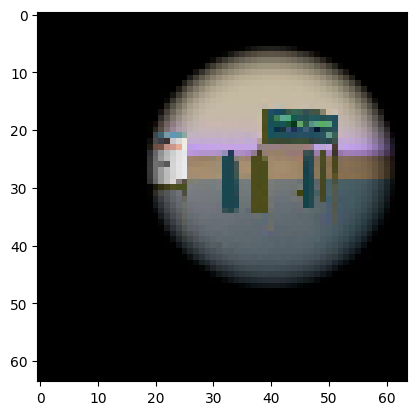

In [37]:
import ast

img = df.loc[df['frame'] == 9075]
R = ast.literal_eval(*img['R'])
G = ast.literal_eval(*img['G'])
B = ast.literal_eval(*img['B'])
fin_img = np.array([R, G, B])
fin_img = fin_img.reshape(3, 64, 64)

print(fin_img.shape)
plt.imshow(fin_img.transpose(1, 2, 0))
plt.show()

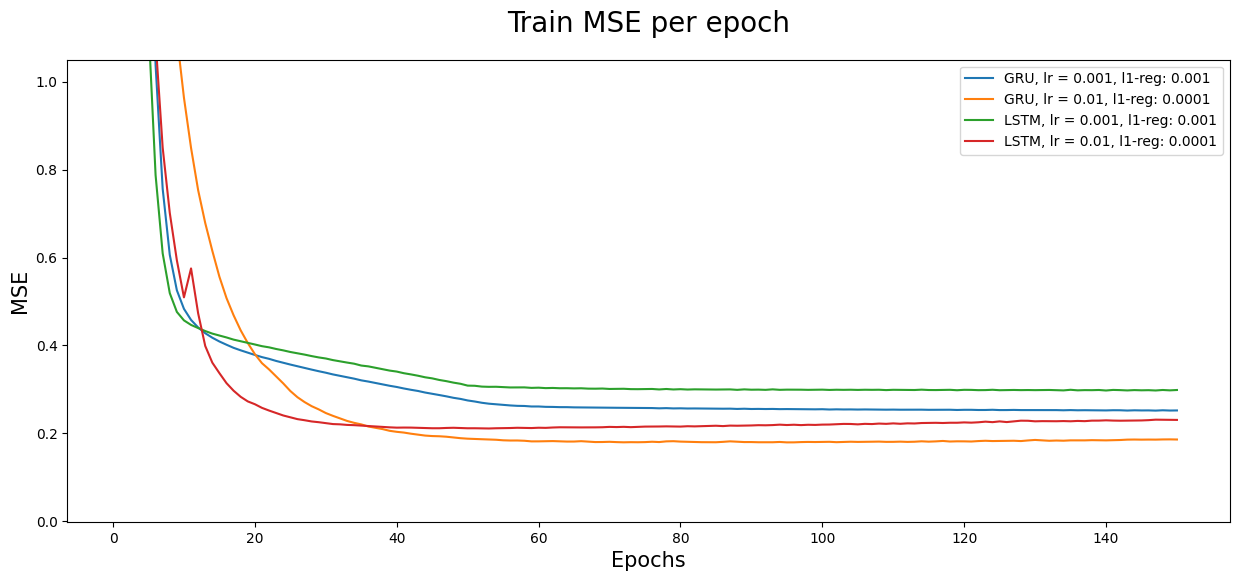

In [43]:
df_gru1 = pd.read_csv('runs/GRU_reg_0.001_lr_0.001_train.csv')
df_gru2 = pd.read_csv('runs/GRU_reg_0.0001_lr_0.01_train.csv')
df_lstm1 = pd.read_csv('runs/LSTM_reg_0.001_lr_0.001_train.csv')
df_lstm2 = pd.read_csv('runs/LSTM_reg_0.0001_lr_0.01_train.csv')

plt.figure(figsize=(15,6))
plt.plot(df_gru1['Step'], df_gru1['Value'], label='GRU, lr = 0.001, l1-reg: 0.001')
plt.plot(df_gru2['Step'], df_gru2['Value'], label='GRU, lr = 0.01, l1-reg: 0.0001')
plt.plot(df_lstm1['Step'], df_lstm1['Value'], label='LSTM, lr = 0.001, l1-reg: 0.001')
plt.plot(df_lstm2['Step'], df_lstm2['Value'], label='LSTM, lr = 0.01, l1-reg: 0.0001')
plt.legend(fontsize=10)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.title('Train MSE per epoch', fontsize=20, pad=20)
plt.ylim(-.001, 1.05)
plt.show()

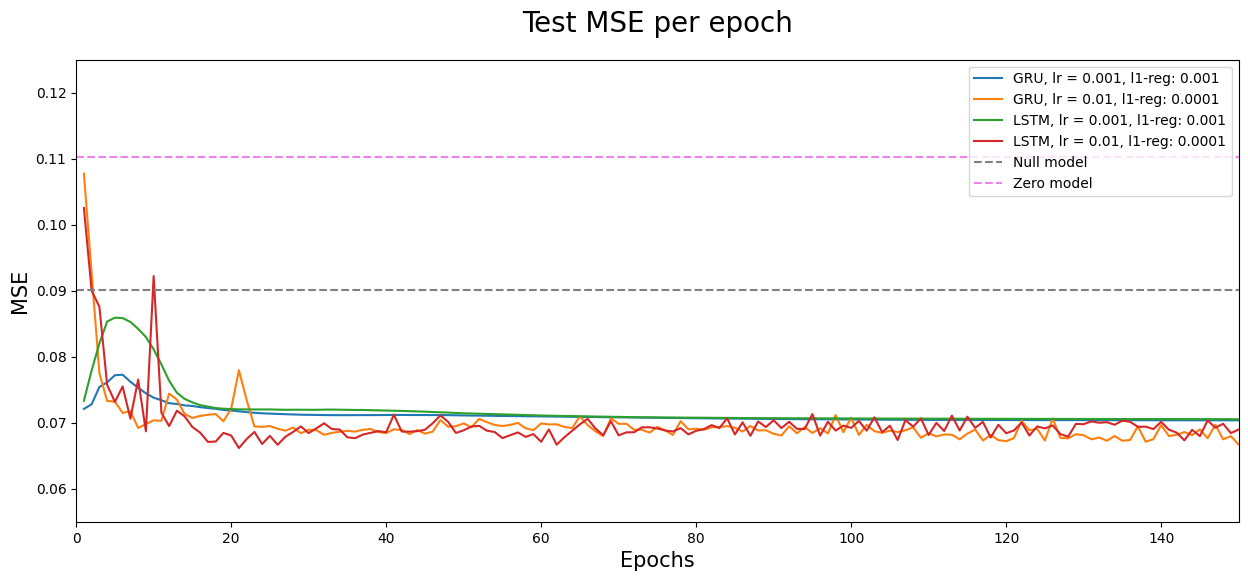

In [62]:
df_gruT1 = pd.read_csv('runs/GRU_reg_0.001_lr_0.001_test.csv')
df_gruT2 = pd.read_csv('runs/GRU_reg_0.0001_lr_0.01_test.csv')
df_lstmT1 = pd.read_csv('runs/LSTM_reg_0.001_lr_0.001_test.csv')
df_lstmT2 = pd.read_csv('runs/LSTM_reg_0.0001_lr_0.01_test.csv')

plt.figure(figsize=(15,6))
plt.plot(df_gruT1['Step'], df_gruT1['Value'], label='GRU, lr = 0.001, l1-reg: 0.001')
plt.plot(df_gruT2['Step'], df_gruT2['Value'], label='GRU, lr = 0.01, l1-reg: 0.0001')
plt.plot(df_lstmT1['Step'], df_lstmT1['Value'], label='LSTM, lr = 0.001, l1-reg: 0.001')
plt.plot(df_lstmT2['Step'], df_lstmT2['Value'], label='LSTM, lr = 0.01, l1-reg: 0.0001')
plt.hlines(0.0901, -50, 200, label='Null model', colors='grey', linestyles='dashed')
plt.hlines(0.1103, -50, 200, label='Zero model', colors='violet', linestyles='dashed')
plt.legend(fontsize=10)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.title('Test MSE per epoch', fontsize=20, pad=20)
plt.ylim(.055, 0.125)
plt.xlim(0, 150)
plt.show()

In [42]:
from ast import literal_eval

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import tqdm
from sklearn.metrics import (average_precision_score, roc_auc_score,
                             root_mean_squared_error, mean_squared_error)
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

from models import MLP, LeNet, actionLSTM, actionGRU
from utils import create_train_test_split

device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
# For data collection, change to True if want to evaluate output 
verbose = False

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# seq_size = how long is each sequence, start_pred = when to start predicting thumbstick movement
seq_size = 30
batch_size = 10
start_pred = 16
epochs = 40
iter_val = 15
img_size = 64
learning_rate = 0.001

game_name = 'Barbie'
dir = r"../Vrnet"

# Create train test split
path_map, train_loader, test_loader, train_seq, test_seq = create_train_test_split(game_name, dir, device, seq_size=seq_size, batch_size=batch_size, iter=iter_val)


In [43]:
train_seq_n = np.array(train_seq)
pred_init = np.array([np.mean(train_seq_n[:,:,2]), np.mean(train_seq_n[:,:,3]), np.mean(train_seq_n[:,:,4]), np.mean(train_seq_n[:,:,5])])

print(pred_init)

[ 0.01179645  0.2537723   0.00433895 -0.00355462]


In [44]:
criterion = torch.nn.MSELoss()

def test(loader, criterion, pred_init):
    rmses = torch.empty(0)
    preds = torch.empty(0)

    with torch.no_grad():
        for batch in loader:
            losses = torch.empty(0).to(device)

            for seq in range(batch.shape[1]-1):
                # (image_ind, path, T1, T2, T3, T4)
                if seq >= start_pred:
                    y = batch[:, seq + 1, 2:]

                    fin = np.tile(pred_init, (y.shape[0], 1))
                    fin = torch.Tensor(fin)

                    preds = torch.cat((preds, y.cpu()))

                    loss = criterion(fin, y)
                    losses = torch.cat((losses, loss.reshape(1)))
            
            losses = torch.mean(losses)
            rmses = torch.cat((rmses, losses.reshape(1).cpu()))

    return sum(rmses) / len(loader), sum(torch.sqrt(rmses)) / len(loader)



In [45]:
print(test(test_loader, criterion, pred_init))

(tensor(0.0901), tensor(0.2980))


In [46]:
zero = np.array([0., 0., 0., 0.])
print(test(test_loader, criterion, zero))

(tensor(0.1103), tensor(0.3291))
